# Vector Search


We can search existing vector data based on any new user input
1. Compute the embedding vector for the query (user input)
2. Find K closest vectors for the query vector

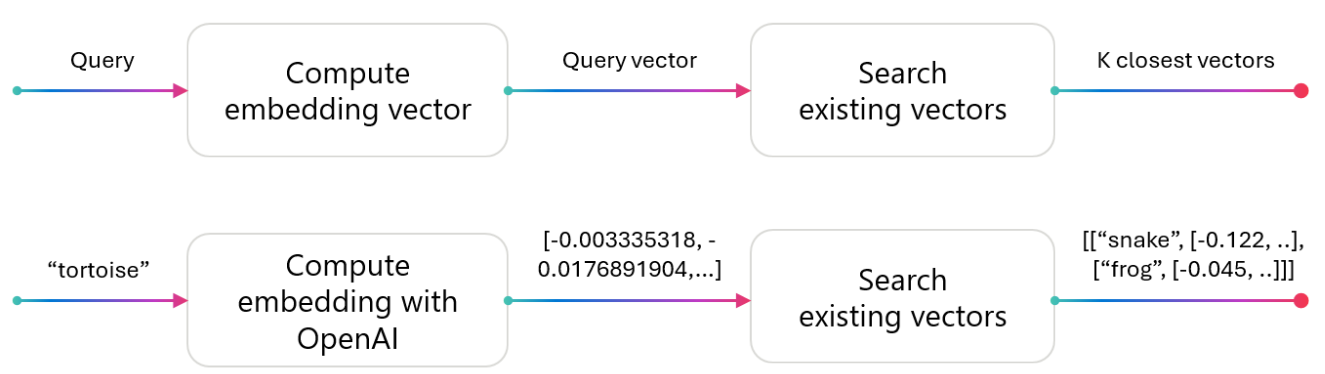

## Setup

In [1]:
import json

with open('embeddings/movies_text-embedding-3-small-1536.json') as f:
    movies = json.load(f)

MODEL_DIMENSIONS = 1536 # Must match the dimension of the embeddings

In [2]:

import os
import openai

openai_client = openai.OpenAI(
    base_url="https://models.github.ai/inference",
    api_key=os.environ["GITHUB_TOKEN"]
)
MODEL_NAME = "openai/text-embedding-3-small"

## Compute embedding

In [3]:
def get_embedding(text):
    embeddings_response = openai_client.embeddings.create(
        model=MODEL_NAME,
        dimensions=MODEL_DIMENSIONS,
        input=text,
    )
    return embeddings_response.data[0].embedding

## Cosine Similarity & Exhaustive Search

In [6]:
import pandas as pd

def cosine_similarity(v1, v2):
    dot_product = sum([a * b for a, b in zip(v1, v2)])
    magnitude = (sum([a**2 for a in v1]) * sum([a**2 for a in v2])) ** 0.5
    return dot_product / magnitude

def exhaustive_search(query_vector, vectors):
    similarities = []
    for title, vector in vectors.items():
        similarity = cosine_similarity(query_vector, vector)
        similarities.append((title, similarity))
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities

new_vector = get_embedding("wayang Disney berkiatan dengan haiwan")
similarities = exhaustive_search(new_vector, movies)
most_similar = similarities[0:10]
similar_movies = [(movie, round(similarity, 3)) for movie, similarity in most_similar]

pd.DataFrame(similar_movies, columns=['movie', 'similarity'])

,movie,similarity
0,The Lion King,0.389
1,The Jungle Book 2,0.365
2,The Jungle Book,0.359
3,The Fox and the Hound,0.337
4,Aladdin,0.329
5,Wild Hogs,0.328
6,Disney's A Christmas Carol,0.326
7,Winnie the Pooh,0.320
8,Monkey Kingdom,0.315
9,Piglet's Big Movie,0.312


# Approximate Nearest Neighbour (ANN) Search

Exhaustive search can be expensive and time consuming in production. ANN search algorithms can speed up search time

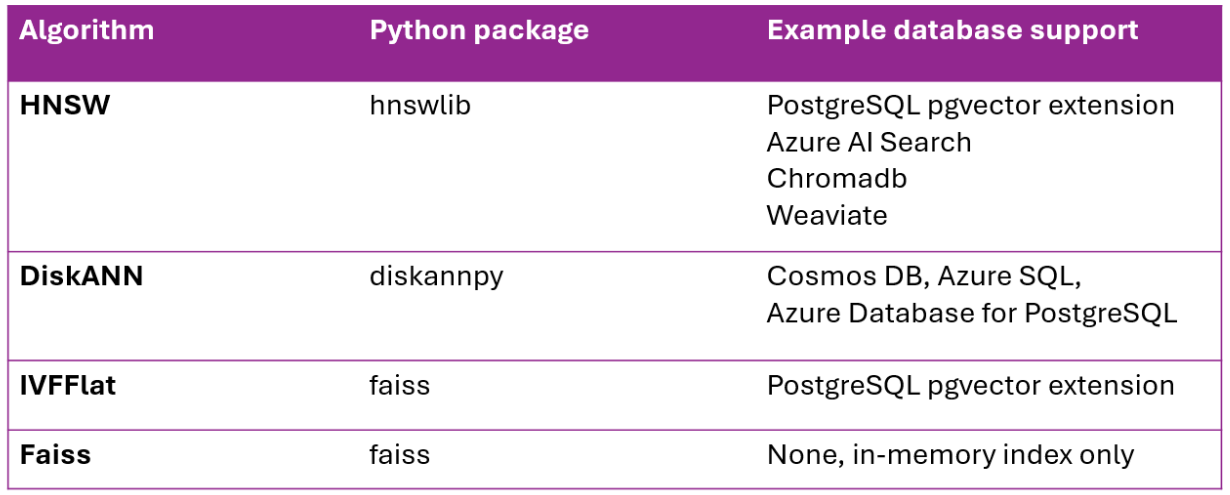

## HNSW : Hierarchical Navegable Small Worlds
Great for:
1. frequently updated index
2. scalable with large indexes

### Creating index
Usually this part would be done in the database, but here is just to show it can be done in python

In [7]:
import hnswlib

# Declaring index
p = hnswlib.Index(space='cosine', dim=1536)

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements=len(movies), ef_construction=200, M=16)

# Element insertion (can be called several times):
vectors = list(movies.values())
ids = list([i for i in range(len(vectors))])
p.add_items(vectors, ids)

# Controlling the recall by setting ef:
p.set_ef(50) # ef should always be > k

### Index parameters are exposed as class properties:
print(f"Parameters passed to constructor:  space={p.space}, dim={p.dim}") 
print(f"Index construction: M={p.M}, ef_construction={p.ef_construction}")
print(f"Index size is {p.element_count} and index capacity is {p.max_elements}")
print(f"Search speed/quality trade-off parameter: ef={p.ef}")

Parameters passed to constructor:  space=cosine, dim=1536
Index construction: M=16, ef_construction=200
Index size is 573 and index capacity is 573
Search speed/quality trade-off parameter: ef=50


### Search the HNSW index

In [12]:
new_vector = get_embedding("wayang Disney berkiatan dengan haiwan")

labels, distances = p.knn_query(new_vector, k=10)

# match labels to movie titles and print out
similar_movies = [(list(movies.keys())[label], round(1 - distance, 3)) for label, distance in zip(labels[0], distances[0])]
pd.DataFrame(similar_movies, columns=['movie', 'similarity'])

,movie,similarity
0,The Lion King,0.389
1,The Jungle Book 2,0.365
2,The Jungle Book,0.359
3,The Fox and the Hound,0.337
4,Aladdin,0.329
5,Wild Hogs,0.328
6,Disney's A Christmas Carol,0.326
7,Winnie the Pooh,0.320
8,Monkey Kingdom,0.315
9,Piglet's Big Movie,0.312


## Use cases

### Product search
https://github.com/Azure-Samples/postgres-agentic-shop

### RAG
Use LLMs to answer questions based off a search of your own data